In [1]:
import pandas as pd
from IPython.display import HTML
import sys
sys.path.append('../')
from src.label import label
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import geopandas

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


## Somerville residential parking inventory

### Status Update

October 8, 2019

Joshua Feldman, Anthony Rentsch, Lipika Ramaswamy


## Satellite Imagery

- Extracted data from ArcMap proprietary format to `.tif` files.
- Each parcel is a standalone file
- Hand-labelling a sample of parcels - 0: no driveway, 1: driveway, 2: don't know

In [2]:
parcels = geopandas.read_file('../data/Parcels_FY19')
print('number of parcels: ',parcels.shape[0])

number of parcels:  14095


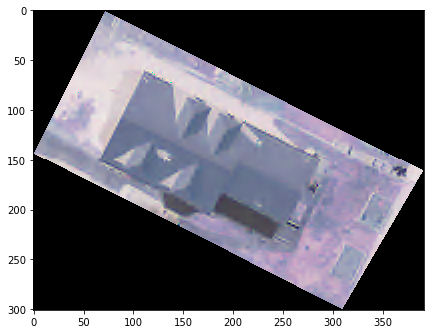

In [ ]:
label()

## Tabular Data

### 1.  **Parking permits** [(link)](https://data.somervillema.gov/City-Services/City-of-Somerville-Parking-Permits/xavb-4s9w)  

**12,797 unique street addresses** after limiting issue date to 2018 and permit type to Residential, New Mass Resident, and Resident - No charge replacement.
    
To confirm: residential parking permits allow Somervile residents to use street parking reserved for residents.

In [3]:
parking_permits = pd.read_csv('../data/City_of_Somerville_Parking_Permits.csv')
# strip extra white space
parking_permits['type_name'] = parking_permits.type_name.str.strip()
parking_permits['st_addr'] = parking_permits.st_addr.str.strip()
parking_permits['st_addr']= parking_permits['st_addr'].apply(lambda mystring: ' '.join(mystring.split()))
# convert issued date to datetime
parking_permits['issued'] = pd.to_datetime(parking_permits['issued'])
# parking_permits.issued year is 2018
parking_permits = parking_permits[parking_permits['issued'].dt.year == 2018]
# subset data to only residential parking permits
residential_permits = parking_permits[parking_permits.type_name.isin(
    ['Residential', 'New Mass Resident', 'Resident - No charge replacement'])]
# aggregate by st addr
res_permits_by_st_addr = residential_permits.groupby('st_addr').aggregate({'issued':len}).reset_index()
res_permits_by_st_addr.columns=['st_addr', 'residential_permits_issued']
print('number of unique street addresses: {}'.format(res_permits_by_st_addr.shape[0]))
res_permits_by_st_addr.head()

number of unique street addresses: 12797


,st_addr,residential_permits_issued
0,1 ALDERSEY ST,1
1,1 AVON ST,3
2,1 BEACON ST,1
3,1 BELMONT SQ,3
4,1 BENTON RD,3


1 Aldersey St has 1 residential parking permit issued, which would allow the residents to park one car on the street in addition to the [three spots in their garage. ](https://www.google.com/maps/place/1+Aldersey+St,+Somerville,+MA+02143/@42.382985,-71.0960374,3a,75y,21.92h,88.7t/data=!3m6!1e1!3m4!1suVgqBBiLUdBI5VRy9pYyYA!2e0!7i16384!8i8192!4m5!3m4!1s0x89e370cca2b22e2d:0x5dbed58b8d9c69f9!8m2!3d42.3830618!4d-71.0958082)


### 2. **Registered Vehicles**  

Using 2017 car registrations as the 2016 registrations will have passed their 2-year expiry.  

Based on `Appendix A: Plate Types`, is it correct to use all Passenger plate types: 'PAN', 'PAR', 'PAS', 'PAV', 'PAY', and Student plate type: 'SPN'?


In [4]:
registered_vehicles = pd.read_excel('../data/COPY_Registered_Vehicles_16_17.xlsx', sheet_name='raw')
print('full dataset size: ',registered_vehicles.shape)
# remove 2016 registrations - car registrations are valid for two years in MA
registered_vehicles = registered_vehicles[registered_vehicles.Year == 2017]
print('2017 dataset size: ',registered_vehicles.shape)
# strip extra white space
registered_vehicles['Plate.Type'] = registered_vehicles['Plate.Type'].str.strip()
registered_vehicles['Address'] = registered_vehicles['Address'].str.strip()
registered_vehicles['Address']= registered_vehicles['Address'].apply(lambda mystring: ' '.join(mystring.split()))
# restrict to plate type categories
categories = ['PAN', 'PAR', 'PAS', 'PAV', 'PAY', 'SPN']
registered_vehicles = registered_vehicles[registered_vehicles['Plate.Type'].isin(categories)]
print('dataset size after restricting to passenger and student vehicles: ', registered_vehicles.shape)
# remove PO box registrations - can't match that up to an address
registered_vehicles = registered_vehicles[~registered_vehicles['Address'].str.contains("PO BOX")]
print('dataset size after removing PO boxes: ', registered_vehicles.shape)
# replace address things like st, rd, ln, etc.
registered_vehicles['Address'] = registered_vehicles['Address'].str.replace(' STREET',' ST')
registered_vehicles['Address'] = registered_vehicles['Address'].str.replace(' ROAD',' RD')
registered_vehicles['Address'] = registered_vehicles['Address'].str.replace(' LANE',' LN')
registered_vehicles['Address'] = registered_vehicles['Address'].str.replace(' DRIVE',' DR')
registered_vehicles['Address'] = registered_vehicles['Address'].str.replace(' AVE',' AV')
registered_vehicles['Address'] = registered_vehicles['Address'].str.replace(' AVNUE',' AV')
registered_vehicles['Address'] = registered_vehicles['Address'].str.replace(' BLVD',' BLV')

full dataset size:  (102132, 9)
2017 dataset size:  (51583, 9)
dataset size after restricting to passenger and student vehicles:  (46802, 9)
dataset size after removing PO boxes:  (45788, 9)


In [5]:
# ACCOUNT FOR DUPLICATE CARS: 
# group by address, city, unit, plate ID (in case of cars that share a license plate)
count_of_duplicates = registered_vehicles.groupby(['Address', 'City', 'Unit', 'PlateID']).aggregate(
    {'EV':len}).reset_index()
count_of_duplicates.rename(columns={'EV':'duplicate_count'}, inplace=True)
print('accounted for {} duplicates'.format(count_of_duplicates[count_of_duplicates.duplicate_count >1].shape[0]))

accounted for 29 duplicates


In [6]:
# now get registered vehicles by address
registered_vehicles_by_addr = count_of_duplicates.groupby(
    ['Address', 'City']).aggregate({'PlateID': len}).reset_index()
registered_vehicles_by_addr.rename(columns={'PlateID':'num_registered_vehicles'}, inplace=True)
print('There are {} unique addresses after preliminary data cleaning.\
 (more cleaning to come)'.format(registered_vehicles_by_addr.shape[0]))

There are 20286 unique addresses after preliminary data cleaning. (more cleaning to come)


Here's a snapshot of the dataset. 

*1 Aldersey St has 2 registered vehicles and 1 parking permit.*

In [7]:
registered_vehicles_by_addr.iloc[1:10,:]

,Address,City,num_registered_vehicles
1,08 GEORGE ST,SOMERVILLE,1
2,1 ALDERSEY ST,SOMERVILLE,2
3,1 ANGELL BROOK DR,W BOYLSTON,1
4,1 AVON ST,SOMERVILLE,3
5,1 BANKS ST,SOMERVILLE,2
6,1 BEACON ST,E SOMERVILLE,1
7,1 BEACON ST,SOMERVILLE,1
8,1 BELMONT SQ UNIT 1,SOMERVILLE,1
9,1 BELMONT SQUARE,SOMERVILLE,2


Here are some addresses with a large number of registered vehicles. Most addresses in Somerville correspont to large apartment buildings, while some out of state ones correspond to insurance offices. Note that we have 29 cars with no address listed.

In [8]:
# here are some interesting ones - where number of registered vehicles is quite large 
## most somerville ones are apartment buildings, but others include a car insurance offie
registered_vehicles_by_addr[registered_vehicles_by_addr.num_registered_vehicles > 20].head()

,Address,City,num_registered_vehicles
0,,,29
52,1 FITCHBURG ST,SOMERVILLE,89
1032,109 HIGHLAND AV,SOMERVILLE,32
1716,1165 SANCTUARY PKWY,ALPHARETTA,21
1773,1188 BROADWAY,SOMERVILLE,23


## Other tabular data sources: 




- Assessment information for buildings?  
    - Something like the property look up tool [here](http://gis.vgsi.com/somervillema/Parcel.aspx?pid=6132) but in tabular form to get information on building sub-areas
    - Any other sources to find garages in parcels
- Permits for paving driveways 
    - ISD Building Permit Daily Applications [here](https://data.somervillema.gov/City-Services/ISD-Building-Permit-Daily-Applications/q3yh-mp87)

## Next steps

- Building a basic model to identify if a parcel has a driveway or not
    - Methods:  Disentangled representations, Active learning, Transfer learning
    
- Evaluating other tabular data sources as labels for models

---